# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print("n_letter:%d"%(n_letters))
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print("n_categories:%d"%(n_categories))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
n_letter:57
Slusarski
n_categories:18


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network
Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

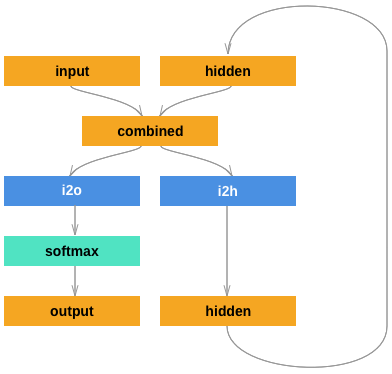

In [27]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [5]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output.shape)
print(torch.exp(output))
print(next_hidden)

torch.Size([1, 18])
tensor([[0.0523, 0.0538, 0.0509, 0.0591, 0.0581, 0.0564, 0.0558, 0.0549, 0.0557,
         0.0567, 0.0518, 0.0537, 0.0531, 0.0519, 0.0629, 0.0612, 0.0554, 0.0564]],
       grad_fn=<ExpBackward0>)
tensor([[ 0.0819, -0.0490, -0.0269, -0.0218, -0.0777,  0.0093, -0.0482, -0.1000,
         -0.0828,  0.0723,  0.0940,  0.0359,  0.1239,  0.0662,  0.0189,  0.1003,
         -0.0448, -0.0202,  0.0899, -0.0392, -0.0731, -0.0864, -0.0236,  0.0314,
          0.0408, -0.0341, -0.0563, -0.0768,  0.0714,  0.0124,  0.0505,  0.0103,
         -0.0490,  0.1185,  0.0171, -0.0779,  0.1192,  0.0734, -0.0627,  0.0216,
         -0.0275, -0.1182, -0.0046, -0.0685,  0.0734,  0.0525,  0.0892, -0.0095,
         -0.0210, -0.0696, -0.0432, -0.1202, -0.0356,  0.0825,  0.0696, -0.0262,
         -0.0456, -0.0137, -0.0492,  0.0313, -0.0578, -0.1410, -0.0052, -0.1311,
          0.0192, -0.0320,  0.0069,  0.0282,  0.0907, -0.0636, -0.0572, -0.0052,
         -0.0983,  0.0655,  0.0033,  0.0631,  0.0680, -0

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [6]:
input = lineToTensor('Albert')#(6*1*57)
print("input.shape",input.shape)
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(torch.exp(output))

input.shape torch.Size([6, 1, 57])
tensor([[0.0523, 0.0538, 0.0509, 0.0591, 0.0581, 0.0564, 0.0558, 0.0549, 0.0557,
         0.0567, 0.0518, 0.0537, 0.0531, 0.0519, 0.0629, 0.0612, 0.0554, 0.0564]],
       grad_fn=<ExpBackward0>)


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 14)


We will also want a quick way to get a training example (a name and its language):

In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Ingledew
category = Italian / line = Stablum
category = Irish / line = Fergus
category = German / line = Marquardt
category = German / line = Farber
category = Arabic / line = Toma
category = Greek / line = Avgerinos
category = Polish / line = Krol
category = Chinese / line = Xing
category = Polish / line = Bosko


### Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [9]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [10]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
current_accuracy = 0
all_losses = []
all_accuracy = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # 添加accuracy
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        current_accuracy += 1
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_accuracy.append(current_accuracy/plot_every)
        current_loss = 0
        current_accuracy = 0

5000 5% (0m 6s) 2.8210 Jordan / Irish ✗ (Polish)
10000 10% (0m 12s) 2.5360 Campbell / Dutch ✗ (Scottish)
15000 15% (0m 18s) 2.1939 Hori / Korean ✗ (Japanese)
20000 20% (0m 24s) 1.2862 Moon / Korean ✓
25000 25% (0m 31s) 2.1791 Abreu / Portuguese ✗ (Spanish)
30000 30% (0m 37s) 2.3888 Hargreaves / Dutch ✗ (English)
35000 35% (0m 43s) 0.0805 Paschalis / Greek ✓
40000 40% (0m 49s) 0.5666 Smolak / Polish ✓
45000 45% (0m 56s) 3.1992 Natale / Arabic ✗ (Italian)
50000 50% (1m 2s) 0.9162 Lapkin / Russian ✓
55000 55% (1m 8s) 3.0363 Koenig / Russian ✗ (German)
60000 60% (1m 14s) 1.0015 Psik / Czech ✓
65000 65% (1m 20s) 0.9138 Daviau / French ✓
70000 70% (1m 27s) 1.9432 Amsel / Arabic ✗ (German)
75000 75% (1m 33s) 0.3223 Glockl / Czech ✓
80000 80% (1m 39s) 5.2813 Gravari / Italian ✗ (Greek)
85000 85% (1m 46s) 1.0880 Malone / Irish ✓
90000 90% (1m 52s) 0.7752 Tron / Vietnamese ✓
95000 95% (1m 58s) 0.8164 Iwahara / Japanese ✓
100000 100% (2m 4s) 0.6500 Safar / Arabic ✓


### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

Text(0.5, 1.0, 'loss')

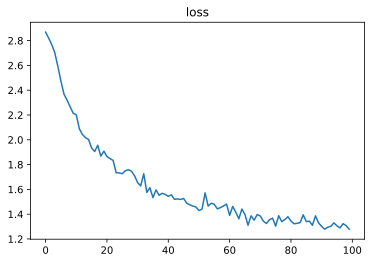

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.title("loss")

Text(0.5, 1.0, 'accuracy')

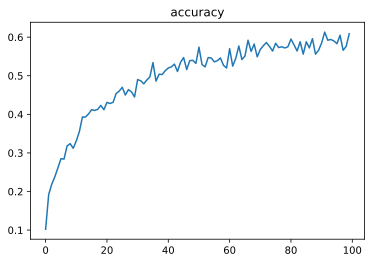

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_accuracy)
plt.title("accuracy")

### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

C:\Users\LHA\AppData\Local\Temp\ipykernel_1796\3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\LHA\AppData\Local\Temp\ipykernel_1796\3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


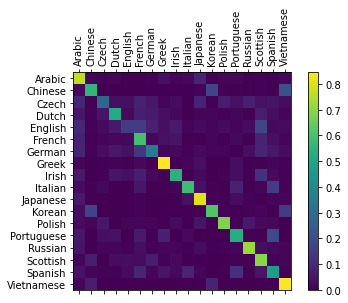

In [145]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

### Running on User Input

In [15]:
import math
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Hou')


> Dovesky
(0.48) Czech
(0.39) Russian
(0.05) English

> Jackson
(0.89) Scottish
(0.05) English
(0.03) Russian

> Hou
(0.43) Chinese
(0.35) Korean
(0.12) Vietnamese


# LSTM 

In [28]:
import torch.nn as nn
import numpy as np
class Lstm_official(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Lstm_official,self).__init__()
        self.lstm=nn.LSTM(input_size,hidden_size,2)
        self.linear=nn.Sequential(
            nn.Linear(hidden_size,output_size),
            nn.LogSoftmax(dim=1)
        )
    def forward(self,input):
        x,(h_n,c_n)=self.lstm(input)
        
        x=self.linear(x[-1])
        
        return x
    
        
n_hidden = 128
Lstm = Lstm_official(n_letters, n_hidden, n_categories)
#测试
input = lineToTensor('Albert')#(6*1*57)
print("input.shape",input.shape)
print(Lstm)

input.shape torch.Size([6, 1, 57])
Lstm_official(
  (lstm): LSTM(57, 128, num_layers=2)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=18, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [15]:
import torch.optim as optim
criterion = nn.NLLLoss()
learning_rate = 0.1 # If you set this too high, it might explode. If too low, it might not learn
optimizer = optim.SGD(Lstm.parameters(), lr=learning_rate)
def train(category_tensor, line_tensor):
    Lstm.zero_grad()
    #此时直接全部输入sequence
    output = Lstm(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
current_accuracy = 0
all_losses1 = []
all_accuracy1 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # 添加accuracy
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        current_accuracy += 1
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses1.append(current_loss / plot_every)
        #print("index:",current_loss / plot_every)
        all_accuracy1.append(current_accuracy/plot_every)
        current_loss = 0
        current_accuracy = 0

5000 5% (0m 8s) 2.2950 Vogts / German ✓
10000 10% (0m 16s) 2.6829 Narvaez / Polish ✗ (Spanish)
15000 15% (0m 24s) 3.2519 Grzeskiewicz / Portuguese ✗ (Polish)
20000 20% (0m 32s) 0.9054 Urbanek / Czech ✓
25000 25% (0m 40s) 0.5190 Rivera / Spanish ✓
30000 30% (0m 48s) 0.5481 Boulos / Arabic ✓
35000 35% (0m 56s) 0.8096 Vico / Italian ✓
40000 40% (1m 4s) 0.0268 Sakanoue / Japanese ✓
45000 45% (1m 12s) 0.1284 Rousseau / French ✓
50000 50% (1m 20s) 0.9779 Kirchma / Czech ✓
55000 55% (1m 28s) 0.1150 Houlis / Greek ✓
60000 60% (1m 36s) 0.2309 Szwedko / Polish ✓
65000 65% (1m 44s) 0.6356 Maloof / Arabic ✓
70000 70% (1m 52s) 0.7328 Esteves / Spanish ✗ (Portuguese)
75000 75% (2m 0s) 0.0690 Akera / Japanese ✓
80000 80% (2m 9s) 0.0208 Plourde / French ✓
85000 85% (2m 17s) 0.0640 Tsehansky / Russian ✓
90000 90% (2m 25s) 0.0343 Pelaez / Spanish ✓
95000 95% (2m 33s) 1.6441 Mencher / English ✗ (Polish)
100000 100% (2m 41s) 0.0555 Seif / Arabic ✓


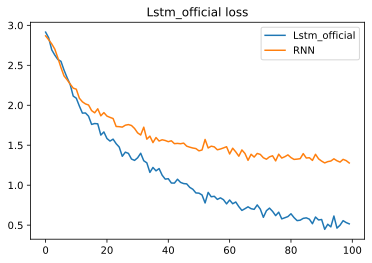

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'svg'
plt.figure()
plt.plot(all_losses1)
plt.plot(all_losses)
plt.title("Lstm_official loss")
plt.legend(["Lstm_official","RNN"])

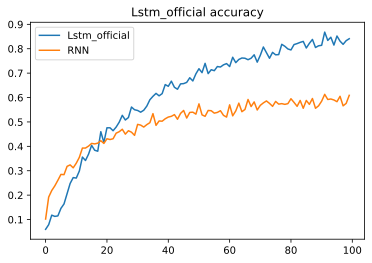

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_accuracy1)
plt.plot(all_accuracy)
plt.title("Lstm_official accuracy")
plt.legend(["Lstm_official","RNN"])

C:\Users\LHA\AppData\Local\Temp\ipykernel_1796\1609557633.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\LHA\AppData\Local\Temp\ipykernel_1796\1609557633.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


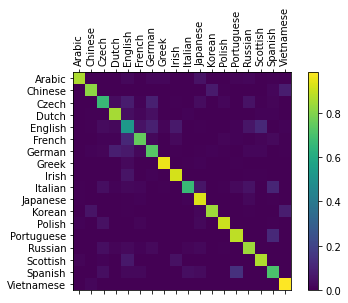

In [75]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    #hidden = Lstm.initHidden()

    #此时直接全部输入sequence
    output = Lstm(line_tensor)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# myLSTM 两层

In [31]:
class myLstmbase(nn.Module):
    def __init__(self,input_sz,hidden_sz):
        super().__init__()
        self.input_size=input_sz
        self.hidden_size=hidden_sz
        #输入参数
        self.U_i=nn.Parameter(torch.Tensor(input_sz,hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz,hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #遗忘门参数
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))

        #记忆门参数
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))

        #输出门参数
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))

        self.init_weights()
    
    # 初始化，采用正态分布
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    # 前向    
    def forward(self,x,h_t,c_t):
        bs,seq_size = x.size()
        #计算
        x_t = x
        i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
        f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
        g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
        o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
        c_t = f_t * c_t + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        hidden_seq=h_t
        return hidden_seq, (h_t, c_t)

# 两层lstm    
class myLstm(nn.Module):
    def __init__(self,input_sz,hidden_sz,output_size):
        super().__init__()
        self.input_size=input_sz
        self.hidden_size=hidden_sz
        # 第一层lstm
        self.lstm1 = myLstmbase(input_sz,hidden_sz)
        # 第二层lstm
        self.lstm2 = myLstmbase(input_sz,hidden_sz)
        # linear
        self.linear=nn.Sequential(
            nn.Linear(hidden_sz,output_size),
            nn.LogSoftmax(dim=1)
        )
    def forward(self,x,h_t,c_t):
        # layer1
        hidden_seq,(temp_h_t,temp_c_t) = self.lstm1(x,h_t,c_t)
        # layer2
        hidden_seq,(temp_h_t,temp_c_t) = self.lstm2(x,temp_h_t,temp_c_t)
        # result
        result = self.linear(hidden_seq)
        return result,(temp_h_t,temp_c_t) 
        
n_hidden = 128
myLstm_model = myLstm(n_letters,n_hidden,n_categories)
input = lineToTensor('Albert')#(6*1*57)
print("input.shape",input.shape)
hidden1 = torch.zeros(1, n_hidden)
hidden2 = torch.zeros(1, n_hidden)
output, (h1,h2)= myLstm_model(input[0], hidden1,hidden2)
print(torch.exp(output))

print(myLstm_model)

input.shape torch.Size([6, 1, 57])
tensor([[0.0567, 0.0606, 0.0608, 0.0573, 0.0523, 0.0524, 0.0549, 0.0552, 0.0516,
         0.0589, 0.0571, 0.0534, 0.0541, 0.0560, 0.0509, 0.0566, 0.0548, 0.0564]],
       grad_fn=<ExpBackward0>)
myLstm(
  (lstm1): myLstmbase()
  (lstm2): myLstmbase()
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=18, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


In [32]:
criterion = nn.NLLLoss()
#learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

import torch.optim as optim
criterion = nn.NLLLoss()
learning_rate = 0.1 # If you set this too high, it might explode. If too low, it might not learn
optimizer = optim.SGD(myLstm_model.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden1 = torch.zeros(1, n_hidden)
    hidden2 = torch.zeros(1, n_hidden)

    myLstm_model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, (hidden1,hidden2) = myLstm_model(line_tensor[i], hidden1,hidden2)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
current_accuracy = 0
all_losses = []
all_accuracy = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # 添加准确率accuracy
    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        current_accuracy +=1

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        all_accuracy.append(current_accuracy/plot_every)
        current_loss = 0
        current_accuracy = 0

5000 5% (0m 39s) 1.4594 Gil / Chinese ✗ (Korean)
10000 10% (1m 18s) 2.8983 Mcneil / Scottish ✗ (Irish)
15000 15% (1m 58s) 0.9851 Armbruster / German ✓
20000 20% (2m 38s) 0.9600 Luo / Vietnamese ✗ (Chinese)
25000 25% (3m 17s) 1.8805 Rompaeij / French ✗ (Dutch)
30000 30% (3m 55s) 0.5078 Dang / Vietnamese ✓
35000 35% (4m 32s) 1.4474 Chan / Vietnamese ✗ (Chinese)
40000 40% (5m 10s) 0.6636 Herrera / Spanish ✓
45000 45% (5m 47s) 2.4337 Driml / English ✗ (Czech)
50000 50% (6m 26s) 0.2970 Egami / Japanese ✓
55000 55% (7m 3s) 0.0528 San nicolas / Spanish ✓
60000 60% (7m 40s) 0.0487 Ryu / Korean ✓
65000 65% (8m 18s) 0.3741 Cleirigh / Irish ✓
70000 70% (8m 55s) 1.9288 Jovnerik / Czech ✗ (Russian)
75000 75% (9m 32s) 0.0320 Romijn / Dutch ✓
80000 80% (10m 10s) 0.0008 Abboud / Arabic ✓
85000 85% (10m 48s) 0.7356 Weichert / Czech ✓
90000 90% (11m 26s) 0.0038 O'Brian / Irish ✓
95000 95% (12m 3s) 0.0490 Close / Greek ✓
100000 100% (12m 40s) 0.0780 Fortier / French ✓


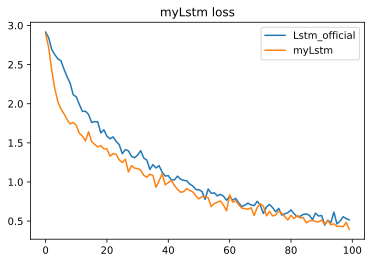

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'svg'
plt.figure()
plt.plot(all_losses1)
plt.plot(all_losses)
plt.title("myLstm loss")
plt.legend(["Lstm_official","myLstm"])

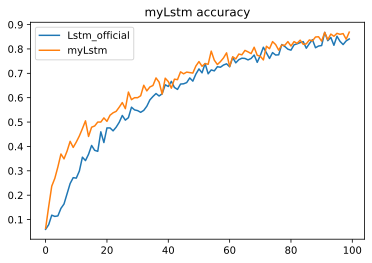

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_accuracy1)
plt.plot(all_accuracy)
plt.title("myLstm accuracy")
plt.legend(["Lstm_official","myLstm"])

C:\Users\LHA\AppData\Local\Temp\ipykernel_1796\2098083784.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\LHA\AppData\Local\Temp\ipykernel_1796\2098083784.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


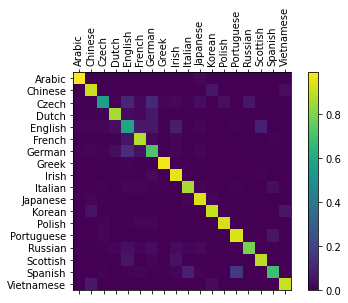

In [149]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden1 = torch.zeros(1, n_hidden)
    hidden2 = torch.zeros(1, n_hidden)

    for i in range(line_tensor.size()[0]):
        output, (hidden1,hidden2) = myLstm_model(line_tensor[i], hidden1,hidden2)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()